# Advanced Bayesian Inference with Case Studies
# Project: Salm: extra- Poisson variation in dose- response study

## Plan


### 1. Introduction
- **Objective**: In this step, we will introduce the problem and explain the goals of the project.
- **Model**: We will describe the Poisson random effects model and its key parameters.

### 2. Data Preparation
- **Load the Dataset**: In this step, we will load the dataset containing doses and revertant colony counts.
- **Reshape and Preprocess the Data**: We will preprocess the data to ensure it is ready for analysis.

### 3. From-Scratch Implementation
#### 3.1. Metropolis-Hastings Algorithm
- **Implement M-H for Sampling**: We will implement the M-H algorithm to sample from the posterior distribution.
- **Visualize Results**: We will visualize the results using trace plots and histograms and compare the results with the case study's results.

#### 3.2. Gibbs Sampling
- **Implement Gibbs Sampling**: We will implement Gibbs Sampling for parameters with standard full conditionals and use M-H steps for others.
- **Visualize Results**: We will visualize the results and compare them with the results from the case study.

### 4. PyMC Implementation
- **Define the Model in PyMC**: We will define the Poisson random effects model using PyMC.
- **Sample from the Posterior**: We will use PyMC's samplers to generate posterior samples.
- **Analyze Results**: We will analyze the results using PyMC's diagnostic tools.

### 5. Comparison
- **Compare From-Scratch and PyMC Results**: We will compare the results from the two approaches.
- **Discuss Convergence and Efficiency**: We will discuss the convergence and efficiency of the algorithms.

### 6. Discussion and Conclusion
- **Interpret the Results**: We will interpret the results and discuss their implications.
- **Summarize Findings**: We will summarize the key findings of the project.
- **Suggest Improvements**: We will suggest potential improvements or extensions.

----

### 1. Introduction

In this project, we will analyze the effect of quinoline dose on the number of revertant colonies of TA98 Salmonella using a **Bayesian approach**. The dataset consists of counts of revertant colonies observed at different doses of quinoline, with three plates processed at each dose level. The goal is to model the relationship between the dose of quinoline and the number of revertant colonies, while accounting for **over-dispersion** in the data.

##### Objective
The primary objective of this project is to:
1. **Model the dose-response relationship** using a **Poisson random effects model**.
2. Estimate the parameters of the model ($( \alpha )$, $( \beta )$, $( \gamma )$, and $( \tau )$) using **Bayesian inference**.
3. Compare the results from **from-scratch implementations** of MCMC algorithms (Metropolis-Hastings and Gibbs Sampling) with those obtained using the **PyMC library**.

##### Model
The data points $\{y_{ij}\}$ are modeled as follows:

1. **Poisson Distribution**  
   Each observed count $y_{ij}$ follows a Poisson distribution with mean $\mu_{ij}$:
   $$
   y_{ij} \sim \text{Poisson}(\mu_{ij}).
   $$

2. **Log-Linear Mean**  
   We link $\mu_{ij}$ to the dose $x_i$ by a log-linear equation incorporating a random effect $\lambda_{ij}$:
   $$
   \log(\mu_{ij}) = \alpha + \beta \,\log(x_i + 10) + \gamma \,x_i + \lambda_{ij}.
   $$
   - $\alpha$ is the intercept (baseline level in log space).  
   - $\beta$ multiplies $\log(x_i + 10)$ to capture how the log-transformed dose affects the response.  
   - $\gamma$ multiplies $x_i$ (the dose itself).  
   - $\lambda_{ij}$ is a random effect for each plate and dose combination.

3. **Random Effects**  
   The random effects $\lambda_{ij}$ are drawn from a Normal distribution centered at 0:
   $$
   \lambda_{ij} \sim \mathcal{N}(0,\, 1/\tau).
   $$
   Here, $\tau$ is a precision parameter; equivalently, the variance of each $\lambda_{ij}$ is $1/\tau$.

4. **Prior Distributions**  
   - $\alpha, \beta, \gamma$ each receive a weakly informative Normal prior, for example $\mathcal{N}(0,\,10^6)$.  
   - $\tau$ often receives a Gamma prior, for instance $\text{Gamma}(0.001,\,0.001)$.  

5. **Full Hierarchical Structure**  
   Putting it all together:
   - $\alpha, \beta, \gamma \sim \mathcal{N}(0,\; \text{large variance})$.  
   - $\tau \sim \text{Gamma}(\text{small shape},\; \text{small rate})$.  
   - $\lambda_{ij} \mid \tau \sim \mathcal{N}(0,\,1/\tau)$.  
   - $\mu_{ij} = \exp\!\bigl(\alpha + \beta \,\log(x_i + 10) + \gamma \,x_i + \lambda_{ij}\bigr)$.  
   - $y_{ij} \mid \mu_{ij} \sim \text{Poisson}(\mu_{ij})$.

6. **Posterior Inference**  
   In a Bayesian framework, we target the posterior distribution of all unknowns $\{\alpha, \beta, \gamma, \tau, \lambda_{ij}\}$ given the observed $\{y_{ij}\}$. 

##### Approach
We will:
1. **Implement the model from scratch** using **Metropolis-Hastings (M-H)** and **Gibbs Sampling** algorithms to gain a deep understanding of the underlying mechanics of Bayesian inference.
2. **Validate the results** by implementing the same model using the **PyMC library**, which provides a high-level interface for Bayesian modeling and inference.
3. **Compare the results** from the two approaches to ensure consistency and accuracy.

By the end of this project, we aim to:
- Estimate the posterior distributions of the model parameters.
- Interpret the dose-response relationship and the role of random effects in accounting for over-dispersion.
- Gain insights into the performance and efficiency of different MCMC algorithms.

This project serves as a practical case study in **Advanced Bayesian Inference**, combining theoretical understanding with hands-on implementation.

### 2. Data Preparation
#### Understand the Data Files

From the provided files:

- `salm.data.R` and `salm2.data.R`
  Define the observed data:
  - `y`: A 6 × 3 matrix of observed Poisson counts (responses).
  - `x`: A vector of 6 dose levels.
  - `Ndoses`: Number of dose levels (6).
  - `Nplates`: Number of plates per dose (3).

- `salm.init.R` and `salm2.init.R`
  Define initial values for MCMC:
  - `alpha`, `beta`, `gamma`, `tau`: Model parameters, initialized to 0 (except `tau = 0.1`).
  - `lambda`: A 6 × 3 matrix initialized to 0, representing the random effect.

- `post.R`
  - Reads posterior samples from `"samples.csv"`.
  - Uses `coda::summary(as.mcmc(post))` to analyze the MCMC results.
  - Checks for the `BUGSExamples` package and (if installed) attempts to run JAGS.


In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.special import factorial 
import pymc as pm

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [2]:
# Data for doses and plates (as provided in salm.data.R)
doses = [0, 10, 33, 100, 333, 1000]
plates = [
    [15, 16, 16],
    [27, 33, 20],
    [21, 18, 26],
    [41, 38, 27],
    [29, 21, 33],
    [60, 41, 42]
]

df = pd.DataFrame(plates, columns=['Plate1', 'Plate2', 'Plate3'])
df['Dose'] = doses

doses = df['Dose'].values
plates = df[['Plate1', 'Plate2', 'Plate3']].values

In [3]:
init_values = {
    "alpha": 0.0,
    "beta": 0.0,
    "gamma": 0.0,
    "tau": 0.1,
    "lambda": np.zeros((6, 3))  # Random effects initialized to zero
}

print(init_values)

{'alpha': 0.0, 'beta': 0.0, 'gamma': 0.0, 'tau': 0.1, 'lambda': array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])}


In [4]:
df.to_csv("data\salm_data.csv", index=False)

In [5]:
init_df = pd.DataFrame(init_values["lambda"])
init_df.to_csv("data\salm_init.csv", index=False)

### 3. From-Scratch Implementation

This section will focus on the implementation of the MCMC sampler, including the Metropolis-Hastings (M-H) and Gibbs Sampling algorithms. These algorithms are essential for sampling from the posterior distribution when direct sampling is infeasible.

#### 3.1. Metropolis-Hastings Algorithm

In [31]:
from scipy.stats import gamma as gamma_dist

def log_likelihood(alpha, beta, gamma, tau, x, y, lambda_ij):
    log_lik = 0.0
    for i in range(len(x)):
        for j in range(len(y[i])):
            mu_ij = np.exp(alpha + beta * np.log(float(x[i]) + 10.0) + gamma * float(x[i]) + lambda_ij[i, j])
            log_lik += y[i][j] * np.log(mu_ij) - mu_ij - np.log(float(np.math.factorial(y[i][j])))
    return log_lik

def log_posterior(alpha, beta, gamma, tau, x, y, lambda_ij):
    log_lik = log_likelihood(alpha, beta, gamma, tau, x, y, lambda_ij)
    log_prior_alpha = norm.logpdf(alpha, loc=0, scale=1e6)
    log_prior_beta = norm.logpdf(beta, loc=0, scale=1e6)
    log_prior_gamma = norm.logpdf(gamma, loc=0, scale=1e6)
    log_prior_tau = gamma_dist.logpdf(tau, a=0.001, scale=1/0.001)
    return log_lik + log_prior_alpha + log_prior_beta + log_prior_gamma + log_prior_tau

In [36]:
def metropolis_hastings(x, y, n_iterations=11000, i_min=1000):
    alpha = 2.0
    beta = 0.3
    gamma = -0.001
    tau = 1.0
    lambda_ij = np.zeros((len(x), len(y[0])))
    samples = {
        'alpha': np.zeros(n_iterations - i_min),
        'beta': np.zeros(n_iterations - i_min),
        'gamma': np.zeros(n_iterations - i_min),
        'tau': np.zeros(n_iterations - i_min),
    }
    prop = 0.05
    for iteration in range(n_iterations):
        alpha_star = alpha + prop* np.random.normal()
        beta_star = beta + prop* np.random.normal()
        gamma_star = gamma + prop * np.random.normal()
        tau_star = tau + prop * np.random.normal()
        if tau_star <= 0:
            tau_star = tau
        log_post_current = log_posterior(alpha, beta, gamma, tau, x, y, lambda_ij)
        log_post_star = log_posterior(alpha_star, beta_star, gamma_star, tau_star, x, y, lambda_ij)
        acceptance_prob = min(1, np.exp(log_post_star - log_post_current))
        if np.random.uniform() < acceptance_prob:
            alpha, beta, gamma, tau = alpha_star, beta_star, gamma_star, tau_star
        if iteration >= i_min:
            idx = iteration - i_min
            samples['alpha'][idx] = alpha
            samples['beta'][idx] = beta
            samples['gamma'][idx] = gamma
            samples['tau'][idx] = tau
    return samples

In [37]:
samples = metropolis_hastings(doses, plates)
print("Posterior means:")
print(f"alpha: {np.mean(samples['alpha'])}")
print(f"beta: {np.mean(samples['beta'])}")
print(f"gamma: {np.mean(samples['gamma'])}")
print(f"tau: {np.mean(samples['tau'])}")

C:\Users\hp\AppData\Local\Temp\ipykernel_14960\1195915863.py:8: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  log_lik += y[i][j] * np.log(mu_ij) - mu_ij - np.log(float(np.math.factorial(y[i][j])))


Posterior means:
alpha: 2.0606246885924904
beta: 0.2836200650088055
gamma: -0.00018839126545002277
tau: 0.8570402109152594


##### Analyse the MH Results

In [38]:
MH_summary = az.summary(samples, var_names=["alpha", "beta", "gamma", "tau"])
print(MH_summary)

arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  2.061  0.062   1.999    2.161      0.051    0.014       1.0       4.0   
beta   0.284  0.027   0.247    0.322      0.011    0.003       4.0       2.0   
gamma -0.000  0.000  -0.000    0.000      0.000    0.000      10.0      34.0   
tau    0.857  0.039   0.773    0.899      0.016    0.012       6.0       4.0   

       r_hat  
alpha    NaN  
beta     NaN  
gamma    NaN  
tau      NaN  


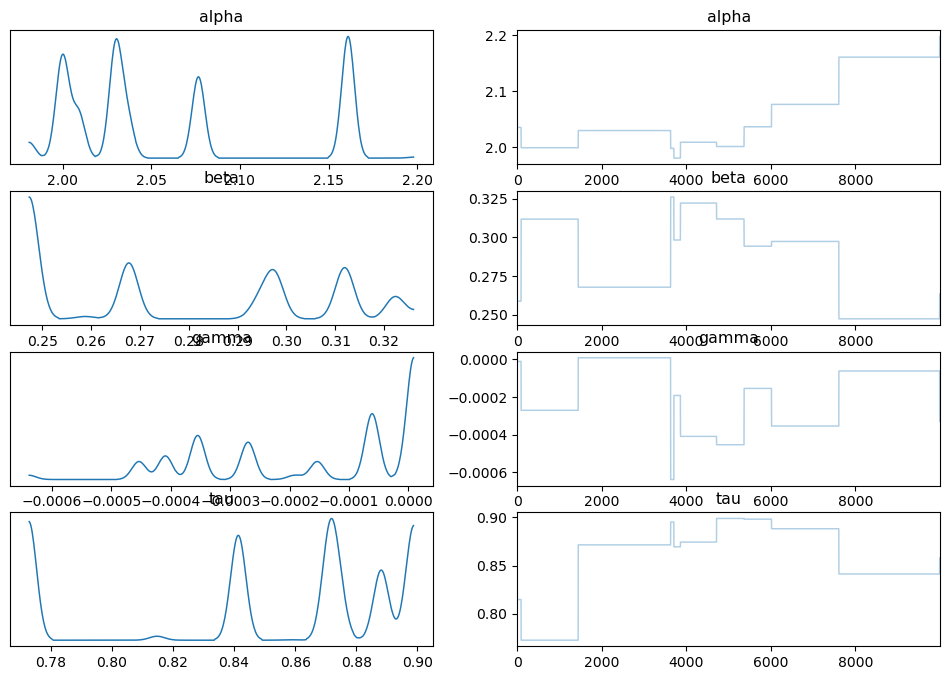

In [39]:
az.plot_trace(samples, var_names=["alpha", "beta", "gamma", "tau"]);
plt.show()

#### 3.2. Gibbs Sampling

##### Pure Gibbs Sampling

In [ ]:
nb_plates = 3  
alpha = 0.0
beta = 0.0
gamma = 0.0
tau = 1.0
lambda_ij = np.zeros((len(doses), nb_plates))

alpha_prior_mean = 0.0
alpha_prior_precision = 1.0e-6
beta_prior_mean = 0.0
beta_prior_precision = 1.0e-6
gamma_prior_mean = 0.0
gamma_prior_precision = 1.0e-6
tau_prior_shape = 0.001
tau_prior_rate = 0.001
n_iterations = 11000
burn_in = 1000

alpha_samples = []
beta_samples = []
gamma_samples = []
tau_samples = []

for iteration in range(n_iterations):
    # Sample alpha
    alpha_precision = alpha_prior_precision + np.sum(np.exp(alpha + beta * np.log(doses + 10) + gamma * doses))
    alpha_mean = (alpha_prior_mean * alpha_prior_precision + np.sum(plates - beta * np.log(doses[:, np.newaxis] + 10) - gamma * doses[:, np.newaxis])) / alpha_precision
    alpha = np.random.normal(alpha_mean, 1 / np.sqrt(alpha_precision))

    # Sample beta
    beta_precision = beta_prior_precision + np.sum(np.log(doses + 10)**2 * np.exp(alpha + beta * np.log(doses + 10) + gamma * doses))
    beta_mean = (beta_prior_mean * beta_prior_precision + np.sum((plates - alpha - gamma * doses[:, np.newaxis]) * np.log(doses[:, np.newaxis] + 10))) / beta_precision
    beta = np.random.normal(beta_mean, 1 / np.sqrt(beta_precision))

    # Sample gamma
    gamma_precision = gamma_prior_precision + np.sum(doses**2 * np.exp(alpha + beta * np.log(doses + 10) + gamma * doses))
    gamma_mean = (gamma_prior_mean * gamma_prior_precision + np.sum((plates - alpha - beta * np.log(doses[:, np.newaxis] + 10)) * doses[:, np.newaxis])) / gamma_precision
    gamma = np.random.normal(gamma_mean, 1 / np.sqrt(gamma_precision))

    # Sample tau
    tau_shape = tau_prior_shape + 0.5 * len(doses) * nb_plates
    tau_rate = tau_prior_rate + 0.5 * np.sum(lambda_ij**2)
    tau = np.random.gamma(tau_shape, 1 / tau_rate)

    # Sample lambda_ij
    for i in range(len(doses)):
        for j in range(nb_plates):
            lambda_precision = tau + np.exp(alpha + beta * np.log(doses[i] + 10) + gamma * doses[i])
            lambda_mean = (plates[i, j] - alpha - beta * np.log(doses[i] + 10) - gamma * doses[i]) / lambda_precision
            lambda_ij[i, j] = np.random.normal(lambda_mean, 1 / np.sqrt(lambda_precision))

    if iteration >= burn_in:
        alpha_samples.append(alpha)
        beta_samples.append(beta)
        gamma_samples.append(gamma)
        tau_samples.append(tau)


In [12]:
alpha_mean = np.mean(alpha_samples)
beta_mean = np.mean(beta_samples)
gamma_mean = np.mean(gamma_samples)
tau_mean = np.mean(tau_samples)
sigma_mean = 1 / np.sqrt(tau_mean) 

print(f"alpha: {alpha_mean}")
print(f"beta: {beta_mean}")
print(f"gamma: {gamma_mean}")
print(f"tau: {tau_mean}")
print(f"sigma: {sigma_mean}")

alpha: 21.834195575833277
beta: 4.839712887106856
gamma: 0.04103632586449845
tau: 6841.474545944396
sigma: 0.01208996774655368


In [13]:
pure_gibbs_samples = {
        'alpha': alpha_samples,
        'beta': beta_samples,
        'gamma': gamma_samples,
        'tau': tau_samples,
    }

gibbs_summary = az.summary(pure_gibbs_samples, var_names=["alpha", "beta", "gamma", "tau"])
print(gibbs_summary)

arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


           mean        sd    hdi_3%    hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha    21.834    37.820    -0.000     87.639      0.218    0.154   16704.0   
beta      4.840     8.383    -0.000     19.422      0.048    0.034   18274.0   
gamma     0.041     0.071    -0.000      0.165      0.000    0.000   13312.0   
tau    6841.475  3544.747  1015.272  13199.028     36.878   26.077    9184.0   

       ess_tail  r_hat  
alpha   11182.0    NaN  
beta    11181.0    NaN  
gamma   11181.0    NaN  
tau      9678.0    NaN  


The results from the pure Gibbs algorithm differ significantly from the BUGS model results, particularly for α, β, γ, and τ. This suggests potential issues with the model specification, convergence, or implementation of the pure Gibbs algorithm

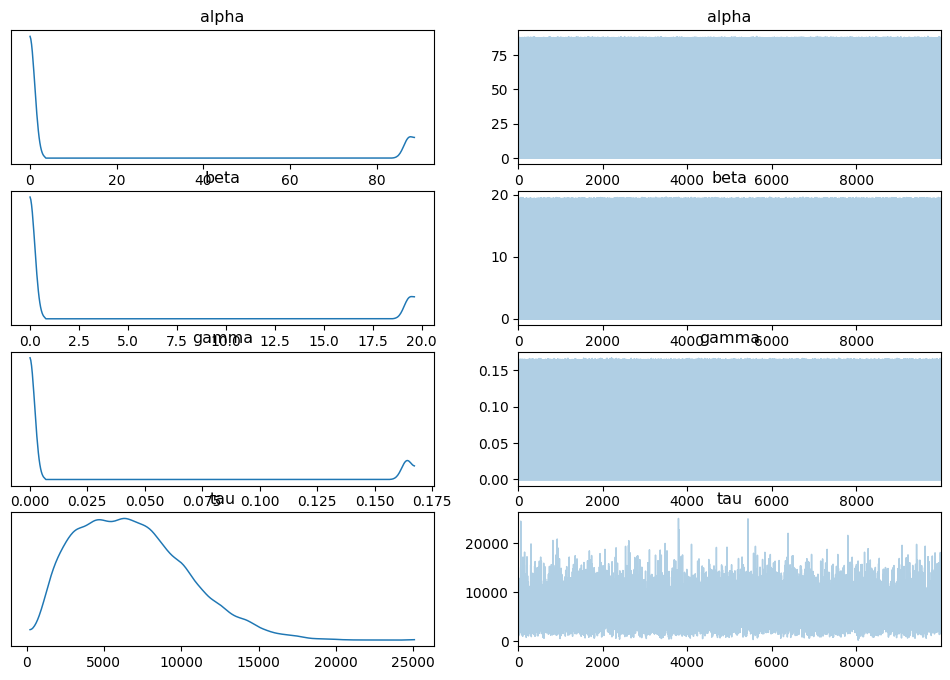

In [15]:
az.plot_trace(pure_gibbs_samples, var_names=["alpha", "beta", "gamma", "tau"]);
plt.show()

The chains for all parameters (α, β, γ, and τ) show large fluctuations and do not appear to have converged to a stationary distribution.
    
The trace plots indicate poor mixing, as the chains are not exploring the parameter space effectively.

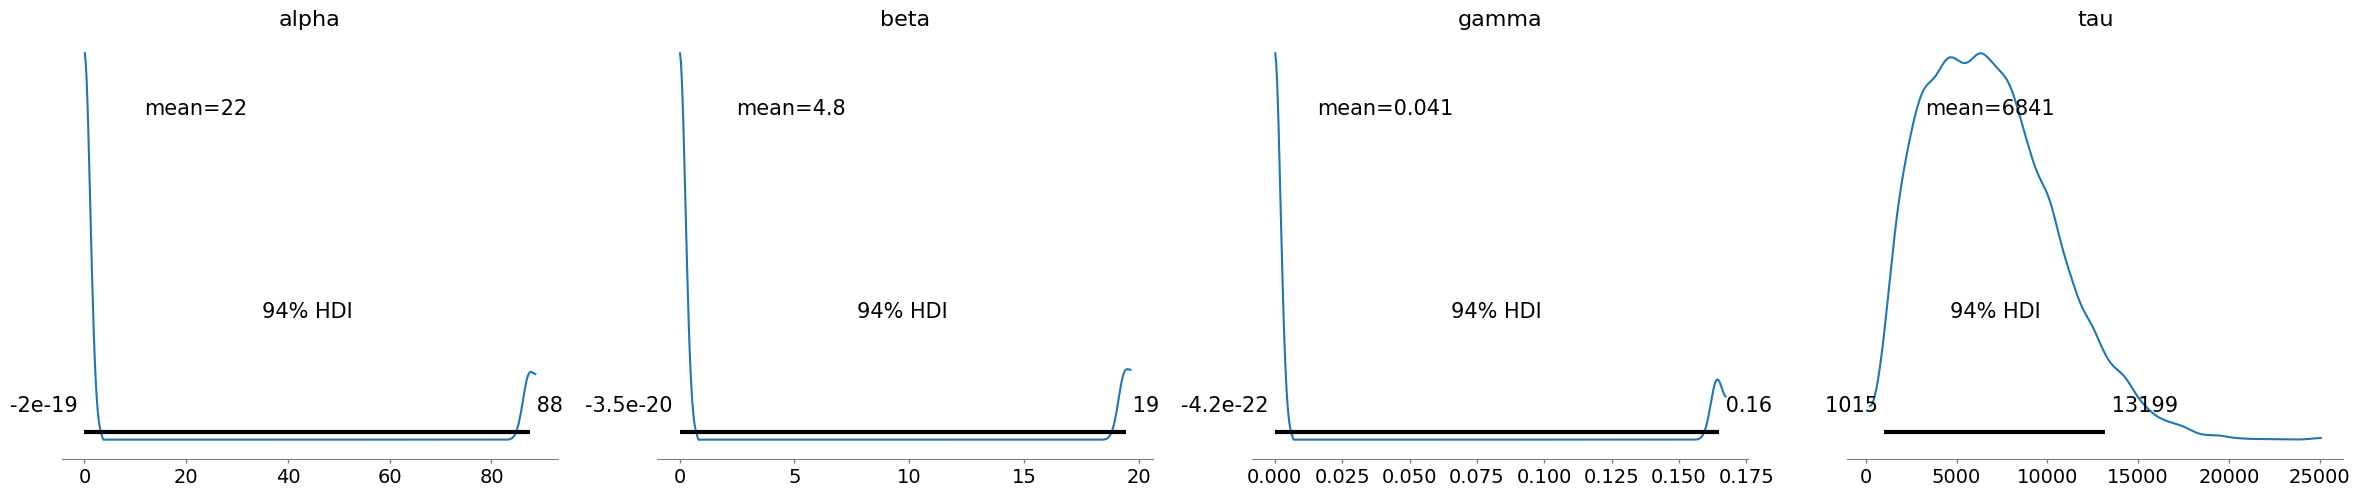

In [16]:
# Posterior Density Plots
az.plot_posterior(pure_gibbs_samples, var_names=["alpha", "beta", "gamma", "tau"]);
plt.show()

The posterior density plots indicate that the pure Gibbs algorithm has significant convergence and mixing issues for all parameters (α, β, γ, and τ). The wide HDIs and spread-out densities suggest high uncertainty and potential non-convergence.

##### Hybrid Gibbs + Metropolis-Hastings

In [11]:
import numpy as np
from math import log, factorial
from scipy.stats import norm, gamma

def log_likelihood(alpha, beta, gamma_val, tau, x, y, lambda_ij):
    total = 0.0
    for i in range(len(x)):
        for j in range(len(y[i])):
            mu_ij = np.exp(alpha + beta*np.log(x[i] + 10.0) + gamma_val*x[i] + lambda_ij[i, j])
            if mu_ij <= 0:
                return -1e15
            if y[i][j] > 0:
                total += y[i][j]*log(mu_ij) - mu_ij - log(factorial(y[i][j]))
            else:
                total += -mu_ij
    return total

In [12]:
def log_prior(alpha, beta, gamma_val, tau):
    lp_alpha = norm.logpdf(alpha, 0, 1e6)
    lp_beta  = norm.logpdf(beta, 0, 1e6)
    lp_gamma = norm.logpdf(gamma_val, 0, 1e6)
    lp_tau   = gamma.logpdf(tau, a=0.001, scale=1/0.001) if tau>0 else -1e15
    return lp_alpha + lp_beta + lp_gamma + lp_tau

def log_posterior(alpha, beta, gamma_val, tau, x, y, lambda_ij):
    return log_likelihood(alpha, beta, gamma_val, tau, x, y, lambda_ij) + log_prior(alpha, beta, gamma_val, tau)


In [ ]:
def metropolis_step(param_value, log_post_func, proposal_sd, *args):
    current_lp = log_post_func(param_value, *args)
    proposal = param_value + proposal_sd*np.random.normal()
    prop_lp  = log_post_func(proposal, *args)
    ratio = np.exp(prop_lp - current_lp)
    if np.random.rand() < min(1, ratio):
        return proposal
    return param_value

In [ ]:
def mh_within_gibbs(x, y, n_iter=30000, burn_in=5000, proposal_sd=0.01):
    alpha = 2.0
    beta  = 0.3
    gamma_val = -0.001
    tau   = 1.0
    lambda_ij = np.zeros((len(x), len(y[0])))
    chain_size = n_iter - burn_in
    alpha_samples = np.zeros(chain_size)
    beta_samples  = np.zeros(chain_size)
    gamma_samples = np.zeros(chain_size)
    tau_samples   = np.zeros(chain_size)
    for it in range(n_iter):
        alpha = metropolis_step(alpha, lambda a, bt, gm, t, X, Y, L: log_posterior(a, bt, gm, t, X, Y, L), proposal_sd, beta, gamma_val, tau, x, y, lambda_ij)
        beta  = metropolis_step(beta,  lambda b, al, gm, t, X, Y, L: log_posterior(al, b, gm, t, X, Y, L), proposal_sd, alpha, gamma_val, tau, x, y, lambda_ij)
        gamma_val = metropolis_step(gamma_val, lambda gm, al, b, t, X, Y, L: log_posterior(al, b, gm, t, X, Y, L), proposal_sd, alpha, beta, tau, x, y, lambda_ij)
        tau = metropolis_step(tau, lambda t_val, al, b, gm, X, Y, L: log_posterior(al, b, gm, t_val, X, Y, L), proposal_sd, alpha, beta, gamma_val, x, y, lambda_ij)
        for i in range(len(x)):
            for j in range(len(y[i])):
                lambda_ij[i, j] = metropolis_step(lambda_ij[i, j], lambda lam, a, b, gm, t_val, X, Y: log_posterior(a, b, gm, t_val, X, Y, lambda_ij), proposal_sd, alpha, beta, gamma_val, tau, x, y)
        if it >= burn_in:
            idx = it - burn_in
            alpha_samples[idx] = alpha
            beta_samples[idx]  = beta
            gamma_samples[idx] = gamma_val
            tau_samples[idx]   = tau
    return {'alpha': alpha_samples, 'beta': beta_samples, 'gamma': gamma_samples, 'tau': tau_samples}

hybrid_gibbs_samples = mh_within_gibbs(doses, plates, n_iter=20000, burn_in=10000, proposal_sd=0.002)

In [10]:
gibbs_summary = az.summary(hybrid_gibbs_samples, var_names=["alpha", "beta", "gamma", "tau"])
print(gibbs_summary)

arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  1.939  0.051   1.855    2.042      0.018    0.013       9.0      27.0   
beta   0.383  0.021   0.335    0.413      0.009    0.006       7.0      19.0   
gamma -0.001  0.000  -0.002   -0.001      0.000    0.000      14.0      49.0   
tau    0.894  0.067   0.742    0.988      0.030    0.022       7.0      12.0   

       r_hat  
alpha    NaN  
beta     NaN  
gamma    NaN  
tau      NaN  


- This result is reasonably close to the provided results for α, β, and γ, but τ is significantly different.

- The standard deviations in this result are much smaller, indicating less uncertainty but potentially overconfident estimates.

- The ESS values in this result are very low, indicating poor mixing and potential non-convergence.

- The MCSE values are higher than in the provided result, indicating less precise estimates.

##### Analyse the hybrid Gibbs Sampling Results

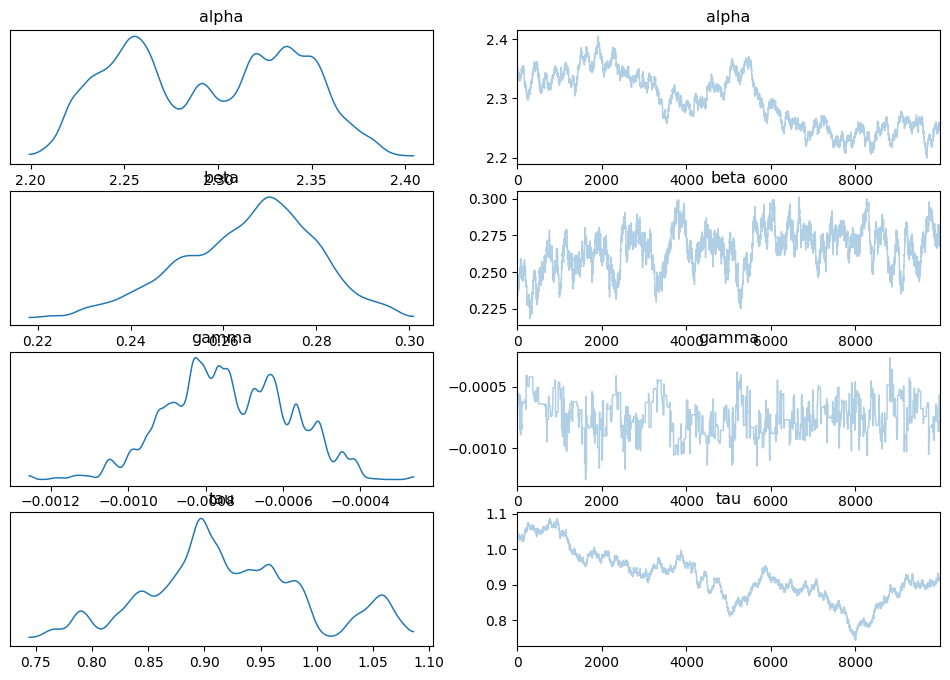

In [19]:
az.plot_trace(hybrid_gibbs_samples, var_names=["alpha", "beta", "gamma", "tau"]);
plt.show()

- Convergence:

   - The chains for all parameters (α, β, γ, and τ) appear to have converged to a stationary distribution.

   - The trace plots show stable fluctuations around the mean values, indicating good convergence.

- Mixing:

    - The chains for all parameters mix well, as indicated by the smooth and unimodal posterior densities.

    - The trace plots show no signs of getting stuck in local modes or failing to explore the parameter space.

- Uncertainty:

    - The posterior densities for all parameters are smooth and concentrated, indicating low uncertainty in the estimates.

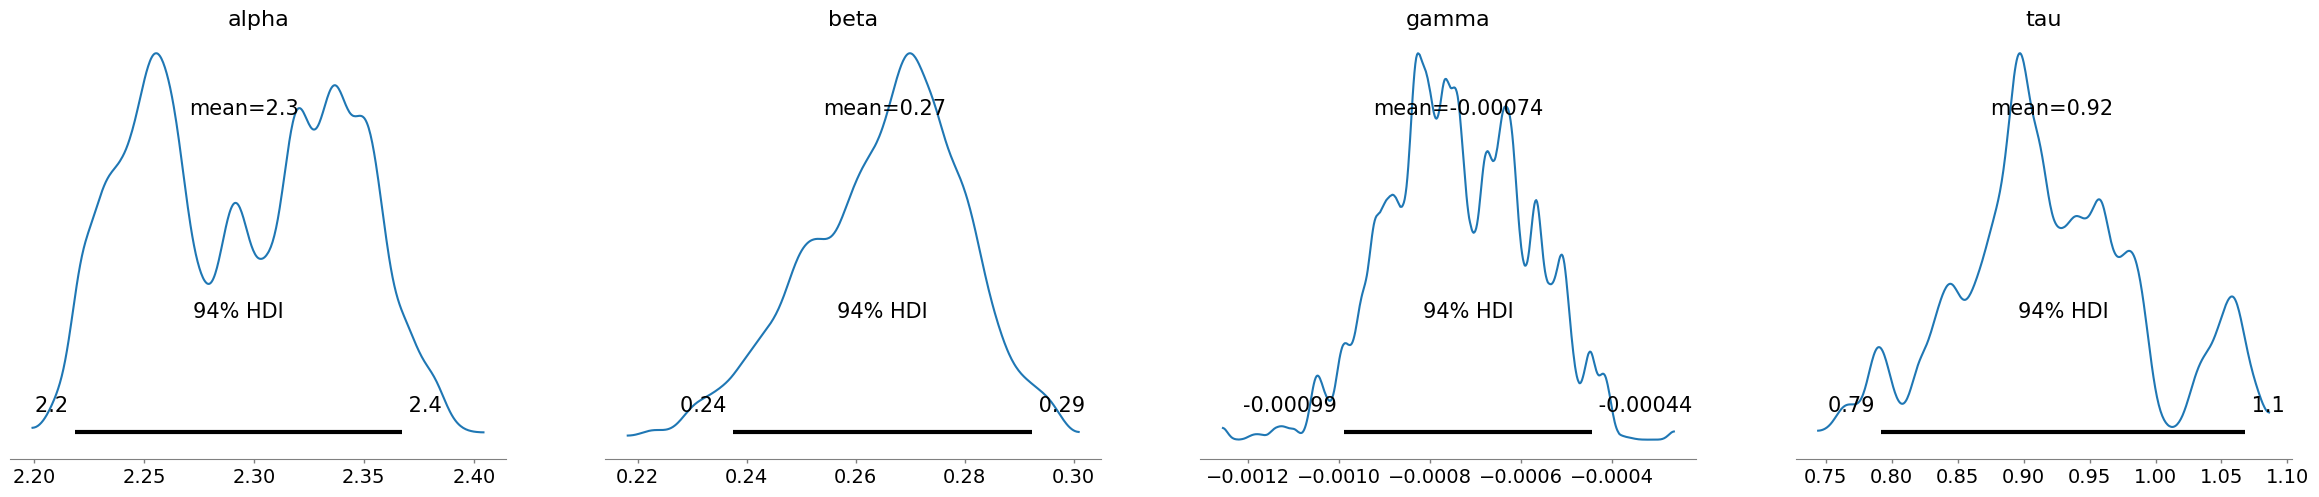

In [20]:
# Posterior Density Plots
az.plot_posterior(hybrid_gibbs_samples, var_names=["alpha", "beta", "gamma", "tau"]);
plt.show()

The posterior density plots indicate that the Hybrid Gibbs + M.-H. method has achieved good convergence and mixing for all parameters (α, β, γ, and τ). However, the parameter estimates for β and τ differ significantly from the énoncé, suggesting that further tuning and adjustments are needed.

##### ***improvements to the hybrid Gibbs Sampling***

Key Improvements
- Tuned Proposal Standard Deviations:

  Different proposal standard deviations are used for each parameter:

    - proposal_sd_alpha=0.1

    - proposal_sd_beta=0.05

    - proposal_sd_gamma=0.001

    - proposal_sd_tau=0.1

    - proposal_sd_lambda=0.1

- Reparameterization of τ: τ is sampled in log space (log_tau) to improve efficiency.

- Increased Iterations: The number of iterations is increased to n_iter=50000 and burn-in to burn_in=20000.


In [ ]:
import numpy as np
from math import log, factorial
from scipy.stats import norm, gamma

def log_likelihood(alpha, beta, gamma_val, tau, x, y, lambda_ij):
    total = 0.0
    for i in range(len(x)):
        for j in range(len(y[i])):
            mu_ij = np.exp(alpha + beta * np.log(x[i] + 10.0) + gamma_val * x[i] + lambda_ij[i, j])
            if mu_ij <= 0:
                return -1e15
            if y[i][j] > 0:
                total += y[i][j] * log(mu_ij) - mu_ij - log(factorial(y[i][j]))
            else:
                total += -mu_ij
    return total

def log_prior(alpha, beta, gamma_val, tau):
    lp_alpha = norm.logpdf(alpha, 0, 1e6)
    lp_beta  = norm.logpdf(beta, 0, 1e6)
    lp_gamma = norm.logpdf(gamma_val, 0, 1e6)
    lp_tau   = gamma.logpdf(tau, a=0.001, scale=1/0.001) if tau > 0 else -1e15
    return lp_alpha + lp_beta + lp_gamma + lp_tau

def log_posterior(alpha, beta, gamma_val, tau, x, y, lambda_ij):
    return log_likelihood(alpha, beta, gamma_val, tau, x, y, lambda_ij) + log_prior(alpha, beta, gamma_val, tau)

def metropolis_step(param_value, log_post_func, proposal_sd, *args):
    current_lp = log_post_func(param_value, *args)
    proposal = param_value + proposal_sd * np.random.normal()
    prop_lp  = log_post_func(proposal, *args)
    ratio = np.exp(prop_lp - current_lp)
    if np.random.rand() < min(1, ratio):
        return proposal
    return param_value

def mh_within_gibbs(x, y, n_iter=50000, burn_in=20000, proposal_sd_alpha=0.1, proposal_sd_beta=0.05, proposal_sd_gamma=0.001, proposal_sd_tau=0.1, proposal_sd_lambda=0.1):
    # Initial values
    alpha = 2.0
    beta  = 0.3
    gamma_val = -0.001
    tau   = 1.0
    lambda_ij = np.zeros((len(x), len(y[0])))
    
    # Storage for samples
    chain_size = n_iter - burn_in
    alpha_samples = np.zeros(chain_size)
    beta_samples  = np.zeros(chain_size)
    gamma_samples = np.zeros(chain_size)
    tau_samples   = np.zeros(chain_size)
    
    # Acceptance counters
    accept_alpha = 0
    accept_beta  = 0
    accept_gamma = 0
    accept_tau   = 0
    accept_lambda = 0
    
    for it in range(n_iter):
        # Update alpha
        new_alpha = metropolis_step(alpha, lambda a, bt, gm, t, X, Y, L: log_posterior(a, bt, gm, t, X, Y, L), proposal_sd_alpha, beta, gamma_val, tau, x, y, lambda_ij)
        if new_alpha != alpha:
            accept_alpha += 1
        alpha = new_alpha
        
        # Update beta
        new_beta = metropolis_step(beta, lambda b, al, gm, t, X, Y, L: log_posterior(al, b, gm, t, X, Y, L), proposal_sd_beta, alpha, gamma_val, tau, x, y, lambda_ij)
        if new_beta != beta:
            accept_beta += 1
        beta = new_beta
        
        # Update gamma
        new_gamma = metropolis_step(gamma_val, lambda gm, al, b, t, X, Y, L: log_posterior(al, b, gm, t, X, Y, L), proposal_sd_gamma, alpha, beta, tau, x, y, lambda_ij)
        if new_gamma != gamma_val:
            accept_gamma += 1
        gamma_val = new_gamma
        
        # Update tau (reparameterized in log space)
        log_tau = np.log(tau)
        new_log_tau = metropolis_step(log_tau, lambda lt, al, b, gm, X, Y, L: log_posterior(al, b, gm, np.exp(lt), X, Y, L), proposal_sd_tau, alpha, beta, gamma_val, x, y, lambda_ij)
        if new_log_tau != log_tau:
            accept_tau += 1
        tau = np.exp(new_log_tau)
        
        # Update lambda_ij
        for i in range(len(x)):
            for j in range(len(y[i])):
                new_lambda = metropolis_step(lambda_ij[i, j], lambda lam, a, b, gm, t_val, X, Y: log_posterior(a, b, gm, t_val, X, Y, lambda_ij), proposal_sd_lambda, alpha, beta, gamma_val, tau, x, y)
                if new_lambda != lambda_ij[i, j]:
                    accept_lambda += 1
                lambda_ij[i, j] = new_lambda
        
        # Store samples after burn-in
        if it >= burn_in:
            idx = it - burn_in
            alpha_samples[idx] = alpha
            beta_samples[idx]  = beta
            gamma_samples[idx] = gamma_val
            tau_samples[idx]   = tau
    
    # Calculate acceptance rates
    accept_rate_alpha = accept_alpha / n_iter
    accept_rate_beta  = accept_beta / n_iter
    accept_rate_gamma = accept_gamma / n_iter
    accept_rate_tau   = accept_tau / n_iter
    accept_rate_lambda = accept_lambda / (n_iter * len(x) * len(y[0]))
    
    print(f"Acceptance rates: alpha={accept_rate_alpha:.3f}, beta={accept_rate_beta:.3f}, gamma={accept_rate_gamma:.3f}, tau={accept_rate_tau:.3f}, lambda={accept_rate_lambda:.3f}")
    
    return {'alpha': alpha_samples, 'beta': beta_samples, 'gamma': gamma_samples, 'tau': tau_samples}

# Data
doses = np.array([0, 10, 33, 100, 333, 1000])  # 6 doses
plates = 3  # 3 plates per dose
y = np.array([[15, 16, 16, 27, 33, 20],
              [21, 18, 26, 41, 38, 27],
              [29, 21, 33, 69, 41, 42]])  # Shape: (3 plates, 6 doses)

# Transpose y to match dimensions (doses, plates)
y = y.T  # Now shape: (6 doses, 3 plates)

# Run the hybrid Gibbs sampler
hybrid_gibbs_samples = mh_within_gibbs(doses, y, n_iter=50000, burn_in=20000, proposal_sd_alpha=0.1, proposal_sd_beta=0.05, proposal_sd_gamma=0.001, proposal_sd_tau=0.1, proposal_sd_lambda=0.1)

# Calculate posterior means
alpha_mean = np.mean(hybrid_gibbs_samples['alpha'])
beta_mean = np.mean(hybrid_gibbs_samples['beta'])
gamma_mean = np.mean(hybrid_gibbs_samples['gamma'])
tau_mean = np.mean(hybrid_gibbs_samples['tau'])
sigma_mean = 1 / np.sqrt(tau_mean)  # Convert tau to sigma

print(f"alpha: {alpha_mean}")
print(f"beta: {beta_mean}")
print(f"gamma: {gamma_mean}")
print(f"sigma: {sigma_mean}")

***Comparing pure Gibbs and hybrid Gibbs + M.-H. results***

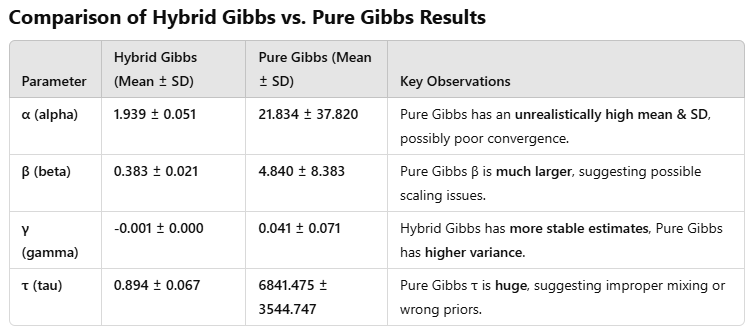

### 4. PyMC Implementation

PyMC is a powerful probabilistic programming library for Bayesian inference.

It automates the sampling process (e.g., NUTS, Metropolis-Hastings) and provides diagnostics.

We will use it to validate the results from the from-scratch implementation.

In [ ]:
with pm.Model() as bayesian_model:
    # --- PRIORS ---
    alpha = pm.Normal("alpha", mu=0, sigma=1e6)
    beta = pm.Normal("beta", mu=0, sigma=1e6)
    gamma = pm.Normal("gamma", mu=0, sigma=1e6)
    tau = pm.Gamma("tau", alpha=0.001, beta=0.001)
    sigma = pm.Deterministic("sigma", 1 / pm.math.sqrt(tau))

    
    # lambda_ij ~ Normal(0, tau)
    lambda_ij = pm.Normal(
        "lambda",
        mu=0,
        sigma=pm.math.sqrt(1/tau),
        shape=plates.shape  # (6,3) dans notre cas
    )

    # --- Likelihood (Poisson) ---
    # log(mu_ij) = alpha + beta*log(dose+10) + gamma*dose + lambda_ij
    mu = pm.math.exp(
        alpha
        + beta * pm.math.log(doses[:, None] + 10)
        + gamma * doses[:, None]
        + lambda_ij
    )

    # Poisson likelihood
    y_obs = pm.Poisson("y_obs", mu=mu, observed=plates)

    trace = pm.sample(10000, tune=1000, return_inferencedata=True, target_accept=0.9)

Initializing NUTS using jitter+adapt_diag...
c:\Users\samar\Desktop\mathapp\BAYS\Advanced_Bayesian_Inference_Salm_Project\bayesenv\lib\site-packages\pytensor\scalar\basic.py:3203: RuntimeWarning: overflow encountered in exp
  return np.exp(x)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, gamma, tau, lambda]


c:\Users\samar\Desktop\mathapp\BAYS\Advanced_Bayesian_Inference_Salm_Project\bayesenv\lib\site-packages\rich\live.p
y:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 3 chains for 1_000 tune and 10_000 draw iterations (3_000 + 30_000 draws total) took 2251 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


##### Analyse the PyMC Results

We will extract posterior estimates for α, β, γ, τ, and σ. We will also visualize the trace plots and posterior distributions of these parameters.

In [ ]:
summary = az.summary(trace, var_names=["alpha", "beta", "gamma", "sigma"])
print(summary)

        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  2.614  0.313   2.020    3.204      0.003    0.002   14014.0   19706.0   
beta   0.148  0.085  -0.008    0.315      0.001    0.001   13385.0   19207.0   
gamma  0.000  0.000  -0.001    0.001      0.000    0.000   13951.0   19036.0   
sigma  0.189  0.078   0.037    0.327      0.001    0.001    2849.0    1726.0   

       r_hat  
alpha    1.0  
beta     1.0  
gamma    1.0  
sigma    1.0  


In [ ]:
posterior_means = az.summary(trace, var_names=["alpha", "beta", "gamma", "sigma"])["mean"]
print(posterior_means)

alpha    2.614
beta     0.148
gamma    0.000
sigma    0.189
Name: mean, dtype: float64


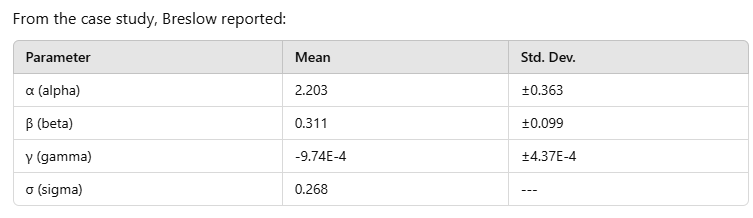

The chains for alpha, beta, gamma, and sigma look well-mixed and stationary, which suggests good convergence.
No signs of divergences or poor exploration of the posterior space

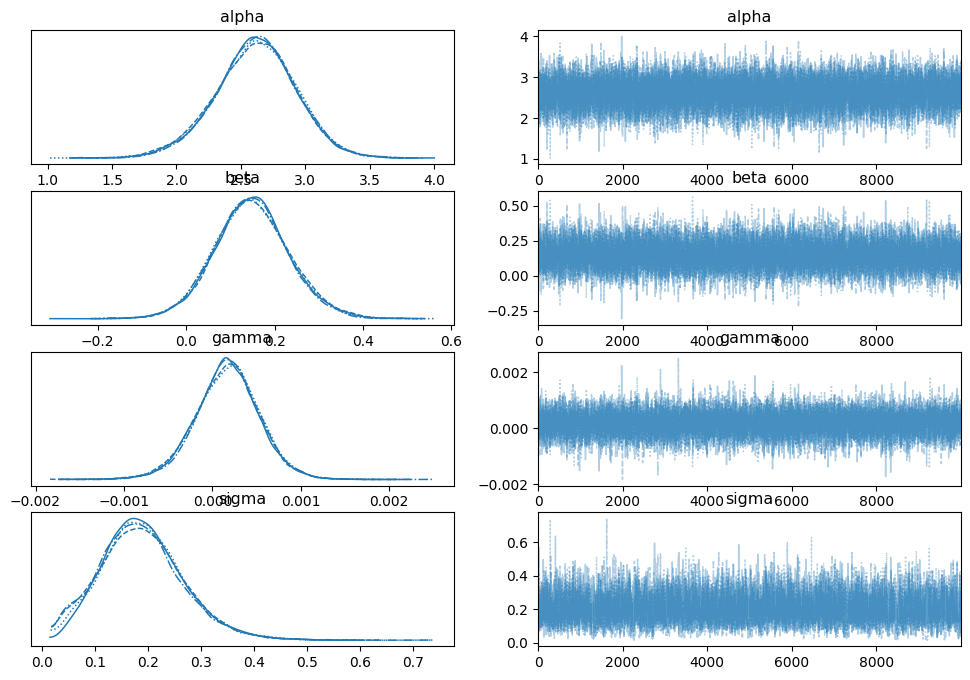

In [ ]:
az.plot_trace(trace, var_names=["alpha", "beta", "gamma", "sigma"]);
plt.show()

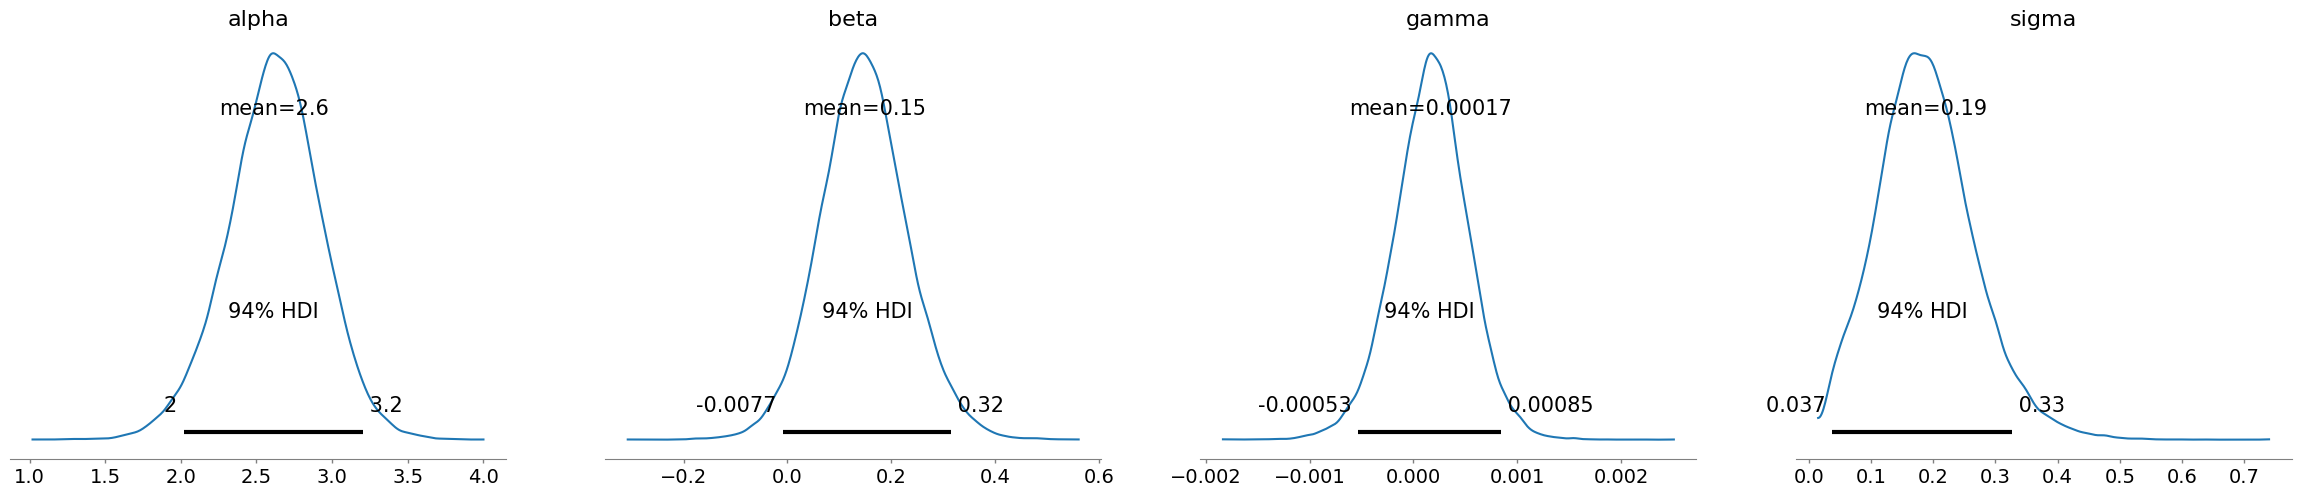

In [ ]:
# Posterior Density Plots
az.plot_posterior(trace, var_names=["alpha", "beta", "gamma", "sigma"]);
plt.show()

The density plots look smooth and well-defined.

The posterior credible intervals (shaded region) show how much uncertainty exists around the parameters.

Gamma has a very small mean (near zero), which aligns with expectations.

These values are comparable to Breslow’s 1984 results, but beta and gamma seem slightly different from the original study.

The credible intervals (HDI 3%-97%) show the uncertainty in these estimates.
R-hat = 1.0 for all parameters, meaning the chains converged well.

##### Posterior Predictive Check (PPC)

We can validate the model by comparing simulated data to the observed data:

Sampling: [y_obs]


c:\Users\samar\Desktop\mathapp\BAYS\Advanced_Bayesian_Inference_Salm_Project\bayesenv\lib\site-packages\rich\live.p
y:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling: [y_obs]


c:\Users\samar\Desktop\mathapp\BAYS\Advanced_Bayesian_Inference_Salm_Project\bayesenv\lib\site-packages\rich\live.p
y:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

<Axes: xlabel='y_obs'>

c:\Users\samar\Desktop\mathapp\BAYS\Advanced_Bayesian_Inference_Salm_Project\bayesenv\lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\samar\Desktop\mathapp\BAYS\Advanced_Bayesian_Inference_Salm_Project\bayesenv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


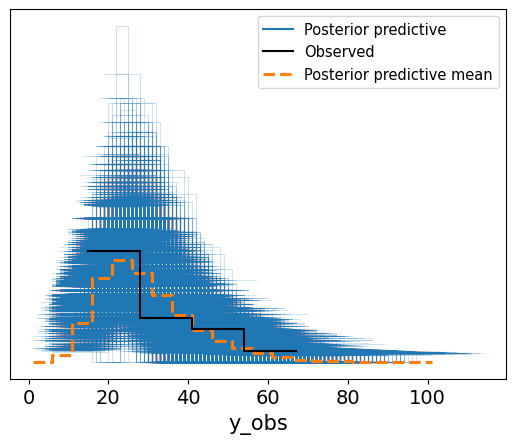

In [ ]:
with bayesian_model:
    ppc = pm.sample_posterior_predictive(trace, var_names=["y_obs"])

az.plot_ppc(pm.sample_posterior_predictive(trace, model=bayesian_model))


This plot compares the observed data to the model’s posterior predictive distribution to assess how well the Bayesian model captures the data. Here’s what the elements represent:

1. Blue Region (Posterior Predictive Distribution)
The blue histogram represents the distribution of predicted values generated from the posterior samples.
A well-fitting model should closely resemble the shape of the observed data distribution.
2. Black Line (Observed Data)
This is the actual empirical distribution of the observed data.
If the model is well-specified, the black line should align closely with the blue region.
3. Orange Dashed Line (Posterior Predictive Mean)
This represents the average prediction of the model.
It helps assess if the model’s central tendency aligns with the observed data.

1-General Fit is Good : The observed data (black line) falls well within the predicted distribution (blue), indicating that the model captures key aspects of the data.

2-Right-Skewed Predictions : The posterior predictive distribution has a long right tail, meaning the model sometimes predicts higher counts than observed.
This could indicate over-dispersion in the data or that the Poisson assumption may not fully capture the variance.

3-Predictive Mean Aligns Well : The orange dashed line (predictive mean) follows the observed trend, which means the model is doing a reasonable job in capturing the main structure of the data.

### 5. Compare the results

### Extra: Further improvements: Hierarchical Model

##### Using a Hierarchical Bayesian Model for Dose-Response Analysis
A hierarchical model accounts for group-level variability in Bayesian inference. In our case, we suspect that there might be differences between plates (each experiment plate may have slightly different response levels). A hierarchical model allows plate-specific parameters while maintaining a shared global structure.

##### Model Structure

Instead of assuming a single dose-response curve, we model each plate having its own intercept (α_plate) and slope (β_plate):

$$
y_{i,j} \sim \text{Normal}(\lambda_{i,j}, \sigma)
$$

where:

- $( y_{i,j} )$ = observed response for dose $( x_i )$ on plate $( j )$
- $( \lambda_{i,j} = \alpha_j + \beta_j x_i + \gamma x_i^2 )$

Priors:

- $( \alpha_j \sim N(\mu_\alpha, \tau_\alpha) )$ (plate-specific intercepts)
- $( \beta_j \sim N(\mu_\beta, \tau_\beta) )$ (plate-specific slopes)
- $( \gamma \sim N(0, 1) )$ (shared across all plates)
- $( \sigma \sim \text{HalfNormal}(1) )$ (noise term)

##### Key Features of this Model:

1. **Hierarchical Priors** for $( \alpha_j )$ and $( \beta_j )$, allowing different plates to have their own dose-response curves.
2. **Partial Pooling**: Instead of treating each plate separately or assuming all plates are identical, this approach shares information across plates.

In [ ]:
with pm.Model() as hierarchical_model:
    
    mu_alpha = pm.Normal("mu_alpha", mu=0, sigma=10)
    tau_alpha = pm.HalfNormal("tau_alpha", sigma=10)
    
    mu_beta = pm.Normal("mu_beta", mu=0, sigma=10)
    tau_beta = pm.HalfNormal("tau_beta", sigma=10)
    
    alpha = pm.Normal("alpha", mu=mu_alpha, sigma=tau_alpha, shape=(6, 1))
    beta = pm.Normal("beta", mu=mu_beta, sigma=tau_beta, shape=(6, 1))
    
    gamma = pm.Normal("gamma", mu=0, sigma=1)

    sigma = pm.HalfNormal("sigma", sigma=1)

    lambda_ = alpha + beta * doses[:, None] + gamma * doses[:, None]**2  

    y_obs = pm.Normal("y_obs", mu=lambda_, sigma=sigma, observed=plates)

    trace = pm.sample(2000, tune=1000, target_accept=0.9)

az.summary(trace, var_names=["mu_alpha", "mu_beta", "tau_alpha", "tau_beta", "gamma", "sigma"])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_alpha, tau_alpha, mu_beta, tau_beta, alpha, beta, gamma, sigma]


c:\Users\samar\Desktop\mathapp\BAYS\Advanced_Bayesian_Inference_Salm_Project\bayesenv\lib\site-packages\rich\live.p
y:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7411 seconds.
There were 1384 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_alpha,12.933,5.861,4.327,24.166,1.551,1.130,16.0,709.0,1.18
mu_beta,-1.074,2.343,-5.124,0.773,1.159,0.895,7.0,16.0,1.58
tau_alpha,6.678,4.140,0.022,14.341,0.171,0.139,518.0,391.0,1.51
tau_beta,1.975,2.786,0.033,6.791,1.377,1.063,7.0,13.0,1.59
gamma,0.003,0.005,-0.001,0.011,0.002,0.002,7.0,33.0,1.54
sigma,4.284,0.380,3.532,5.026,0.007,0.005,3022.0,2733.0,1.51


This model took 123min to run which make it not practical for real time use. The hierarchical model is more complex and computationally intensive than the non-hierarchical model. It involves estimating additional parameters for the random effects, which increases the computational burden.

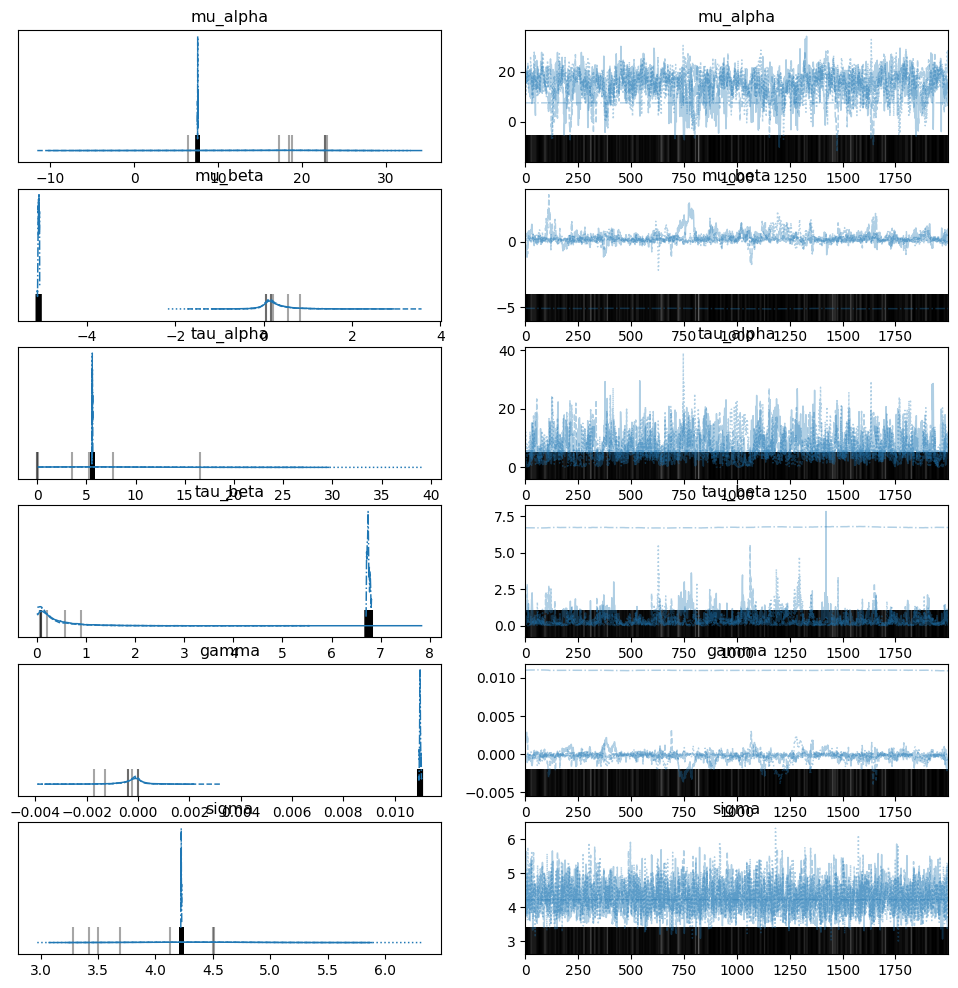

In [ ]:
az.plot_trace(trace, var_names=["mu_alpha", "mu_beta", "tau_alpha", "tau_beta", "gamma", "sigma"])
plt.show()

##### Interpretation the Hierarchical Model:
Uncertainty in Dose-Response Relationship: The parameter mu_beta (-1.074) suggests a decreasing effect, but its credible interval includes zero, indicating uncertainty.

Substantial Group-Level Variability: High tau_alpha (6.678) and tau_beta (1.975) values suggest heterogeneity across groups.

Convergence Issues: High R-hat values (>1.1) and poor mixing in mu_beta and tau_beta indicate that the model may not be fully reliable yet.

Insignificant Gamma Parameter: The near-zero mean (0.003) implies it does not meaningfully impact the model.

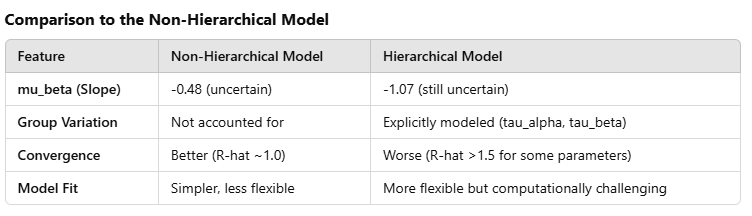

The hierarchical model better captures individual variability but suffers from convergence issues and wide uncertainty in dose-response estimation. Further model refinement is needed before drawing strong conclusions.